In [ ]:
# Install necessary libraries
!pip install -q transformers datasets accelerate scikit-image opencv-python matplotlib torchinfo

Using device: cuda
Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1d7ef230dfbdad(…):   0%|          | 0.00/113M [00:00<?, ?B/s]

data/test-00000-of-00001-0031debf8df4462(…):   0%|          | 0.00/16.3M [00:00<?, ?B/s]

data/valid-00000-of-00001-bce5cef16a5cce(…):   0%|          | 0.00/32.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1502 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/215 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/429 [00:00<?, ? examples/s]

Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 215
    })
    valid: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 429
    })
})
{'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7F8317549910>, 'id': 0, 'category_id': 1, 'bbox': [145.0, 239.0, 168.75, 162.5], 'segmentation': [[313.75, 238.75, 145.0, 238.75, 145.0, 401.25, 313.75, 401.25, 313.75, 238.75]], 'area': 27421.875, 'isc

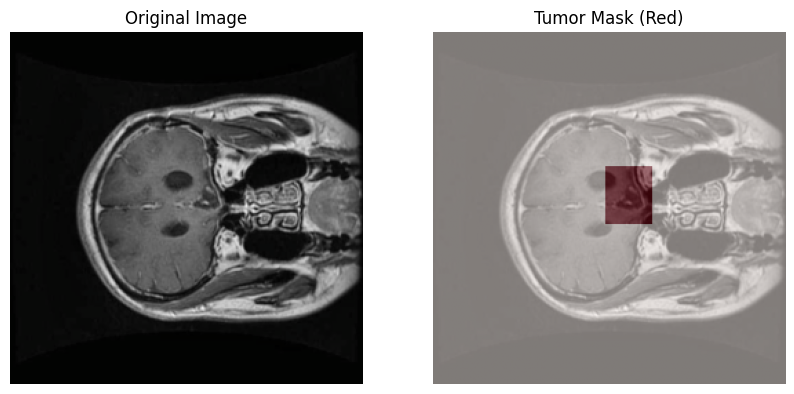

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image, ImageDraw

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
print("Loading dataset...")
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
print("Dataset loaded successfully!")

print(dataset) # for check
print(dataset['train'][0])

# Define transformations
# Resize to a common size, convert to tensor
IMG_SIZE = 256

class BrainTumorDataset(Dataset):
    def __init__(self, hf_dataset, img_size=IMG_SIZE, train=True):
        self.hf_dataset = hf_dataset
        self.img_size = img_size
        self.train = train

        self.transform_img = transforms.Compose([
            transforms.Resize((img_size, img_size), Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
        ])

        self.transform_mask = transforms.Compose([
            transforms.Resize((img_size, img_size), Image.NEAREST), # Nearest for masks to preserve labels
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert("RGB") # Ensure RGB

        # Get original image dimensions for mask creation
        original_width, original_height = image.size

        # Create an empty mask image
        mask_img = Image.new('L', (original_width, original_height), 0)
        # Get segmentation coordinates
        segmentations = item['segmentation']

        # Draw segmentation polygons onto the mask
        if segmentations:
            draw = ImageDraw.Draw(mask_img)
            for seg in segmentations:
                polygon_coords = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                draw.polygon(polygon_coords, outline=1, fill=1)

        # mask transform
        mask = self.transform_mask(mask_img)
        mask = (mask > 0).float() # Converts non-zero pixels to 1.0, zeros to 0.0

        image = self.transform_img(image)

        return image, mask

# Create dataset instances
train_dataset = BrainTumorDataset(dataset['train'])
val_dataset = BrainTumorDataset(dataset['valid'])

# Create DataLoaders
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Shape of one image batch: {next(iter(train_loader))[0].shape}")
print(f"Shape of one mask batch: {next(iter(train_loader))[1].shape}")

# Visualize a sample
def visualize_sample(image_tensor, mask_tensor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Unnormalize image for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_display = inv_normalize(image_tensor).permute(1, 2, 0).cpu().numpy()
    mask_display = mask_tensor.squeeze().cpu().numpy()

    axes[0].imshow(image_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Overlay mask on image for better visualization
    axes[1].imshow(image_display, cmap='gray')
    axes[1].imshow(mask_display, cmap='Reds', alpha=0.5) # Red overlay for tumor
    axes[1].set_title("Tumor Mask (Red)")
    axes[1].axis('off')

    plt.show()

# Get a batch and visualize one sample
images, masks = next(iter(train_loader))
print("Sample image and mask:")
visualize_sample(images[2], masks[2])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTForImageClassification # We'll adapt this for segmentation
from torchinfo import summary

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_output, _ = self.attn(x, x, x)
        x = residual + attn_output

        residual = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = residual + x
        return x

# U-Net Encoder-Decoder with Transformer Integration
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

class TransformerUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1,
                 transformer_embed_dim=256, transformer_heads=8, transformer_mlp_dim=512,
                 num_transformer_blocks=2):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv = ConvBlock(512, 1024)

        # Transformer Integration in Bottleneck
        self.feature_map_size = IMG_SIZE // (2**4) # 256 / 16 = 16
        self.linear_project = nn.Linear(1024, transformer_embed_dim)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(transformer_embed_dim, transformer_heads, transformer_mlp_dim)
              for _ in range(num_transformer_blocks)]
        )
        self.linear_unproject = nn.Linear(transformer_embed_dim, 1024)


        # Decoder
        self.upconv4 = UpConv(1024, 512)
        self.dec4 = ConvBlock(1024, 512)
        self.upconv3 = UpConv(512, 256)
        self.dec3 = ConvBlock(512, 256)
        self.upconv2 = UpConv(256, 128)
        self.dec2 = ConvBlock(256, 128)
        self.upconv1 = UpConv(128, 64)
        self.dec1 = ConvBlock(128, 64)

        # Output Layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck (CNN)
        b = self.bottleneck_conv(p4)

        # Transformer
        b_flat = b.permute(0, 2, 3, 1).contiguous().view(b.size(0), -1, 1024)
        b_trans = self.linear_project(b_flat)
        b_trans = self.transformer_blocks(b_trans)
        b_trans = self.linear_unproject(b_trans)
        # Reshape back to (B, C, H, W)
        b_trans = b_trans.view(b.size(0), self.feature_map_size, self.feature_map_size, 1024).permute(0, 3, 1, 2).contiguous()

        # Combine CNN bottleneck and Transformer output
        refined_bottleneck = b_trans

        # Decoder
        d4 = self.upconv4(refined_bottleneck)
        # print(f"d4 shape: {d4.shape}, e4 shape: {e4.shape}") # Debugging shape mismatch
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return torch.sigmoid(out) # Sigmoid for binary segmentation

# Initialize the model and move to device
model = TransformerUNet(in_channels=3, out_channels=1).to(device)

# Print model summary
summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
TransformerUNet                          [8, 1, 256, 256]          --
├─ConvBlock: 1-1                         [8, 64, 256, 256]         --
│    └─Conv2d: 2-1                       [8, 64, 256, 256]         1,792
│    └─BatchNorm2d: 2-2                  [8, 64, 256, 256]         128
│    └─ReLU: 2-3                         [8, 64, 256, 256]         --
│    └─Conv2d: 2-4                       [8, 64, 256, 256]         36,928
│    └─BatchNorm2d: 2-5                  [8, 64, 256, 256]         128
│    └─ReLU: 2-6                         [8, 64, 256, 256]         --
├─MaxPool2d: 1-2                         [8, 64, 128, 128]         --
├─ConvBlock: 1-3                         [8, 128, 128, 128]        --
│    └─Conv2d: 2-7                       [8, 128, 128, 128]        73,856
│    └─BatchNorm2d: 2-8                  [8, 128, 128, 128]        256
│    └─ReLU: 2-9                         [8, 128, 128, 128]        --
│

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

# Loss Functions: Binary Cross-Entropy Loss
bce_loss = nn.BCELoss()

# Loss
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

# Optimizer
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Parameters
NUM_EPOCHS = 20

# Training
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0 # To track training dice score
        print(f"Epoch {epoch+1}/{num_epochs}")
        for images, masks in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            # Calculate Dice Score for monitoring
            pred_mask = (outputs > 0.5).float()
            train_dice += (1 - dice_loss(pred_mask, masks)).item() * images.size(0)


        train_loss /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset) # Average training Dice

        # Validation
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = combined_loss(outputs, masks)
                val_loss += loss.item() * images.size(0)

                # Calculate Dice Score for monitoring
                pred_mask = (outputs > 0.5).float()
                val_dice += (1 - dice_loss(pred_mask, masks)).item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset) # Average validation Dice


        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved best model!")

# Start training
train_model(model, train_loader, val_loader, optimizer, NUM_EPOCHS, device)

Epoch 1/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.1864, Train Dice: 0.4260, Val Loss: 1.0669, Val Dice: 0.5091
Saved best model!
Epoch 2/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.9776, Train Dice: 0.5735, Val Loss: 0.9226, Val Dice: 0.6195
Saved best model!
Epoch 3/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.8482, Train Dice: 0.6258, Val Loss: 0.8140, Val Dice: 0.6040
Saved best model!
Epoch 4/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.7273, Train Dice: 0.6635, Val Loss: 0.7179, Val Dice: 0.6160
Saved best model!
Epoch 5/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.6174, Train Dice: 0.6997, Val Loss: 0.6431, Val Dice: 0.6662
Saved best model!
Epoch 6/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.5516, Train Dice: 0.7014, Val Loss: 0.5294, Val Dice: 0.7037
Saved best model!
Epoch 7/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.4763, Train Dice: 0.7318, Val Loss: 0.5047, Val Dice: 0.6820
Saved best model!
Epoch 8/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.4285, Train Dice: 0.7425, Val Loss: 0.4455, Val Dice: 0.7187
Saved best model!
Epoch 9/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.3735, Train Dice: 0.7703, Val Loss: 0.4207, Val Dice: 0.7160
Saved best model!
Epoch 10/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.3548, Train Dice: 0.7716, Val Loss: 0.3727, Val Dice: 0.7574
Saved best model!
Epoch 11/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.3230, Train Dice: 0.7867, Val Loss: 0.4460, Val Dice: 0.6860
Epoch 12/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.3022, Train Dice: 0.7970, Val Loss: 0.3464, Val Dice: 0.7597
Saved best model!
Epoch 13/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.2861, Train Dice: 0.8035, Val Loss: 0.3547, Val Dice: 0.7493
Epoch 14/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.2770, Train Dice: 0.8073, Val Loss: 0.3196, Val Dice: 0.7726
Saved best model!
Epoch 15/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.2548, Train Dice: 0.8219, Val Loss: 0.3377, Val Dice: 0.7587
Epoch 16/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.2407, Train Dice: 0.8305, Val Loss: 0.3567, Val Dice: 0.7401
Epoch 17/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.2337, Train Dice: 0.8336, Val Loss: 0.3556, Val Dice: 0.7437
Epoch 18/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.2181, Train Dice: 0.8450, Val Loss: 0.4018, Val Dice: 0.7086
Epoch 19/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.2192, Train Dice: 0.8423, Val Loss: 0.3204, Val Dice: 0.7660
Epoch 20/20


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.1919, Train Dice: 0.8624, Val Loss: 0.2962, Val Dice: 0.7839
Saved best model!


Best model loaded for inference.

Visualizing predictions on validation data:
Sample 1:


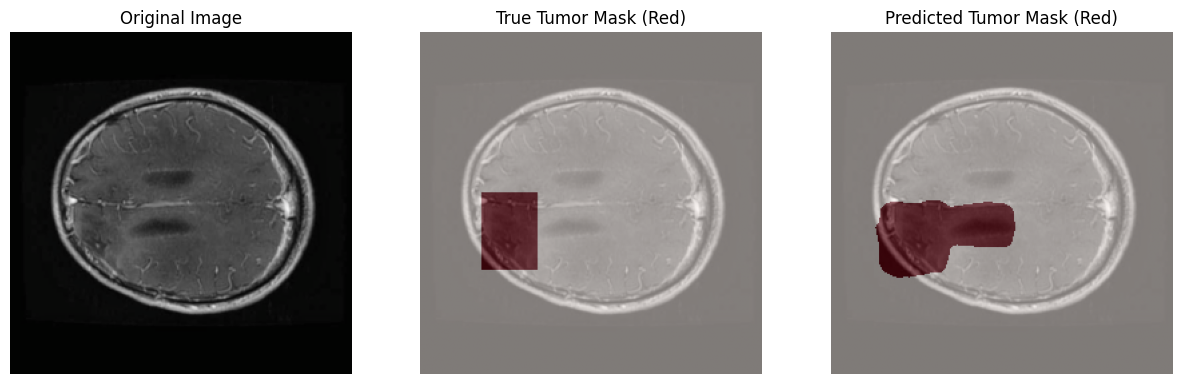

Sample 2:


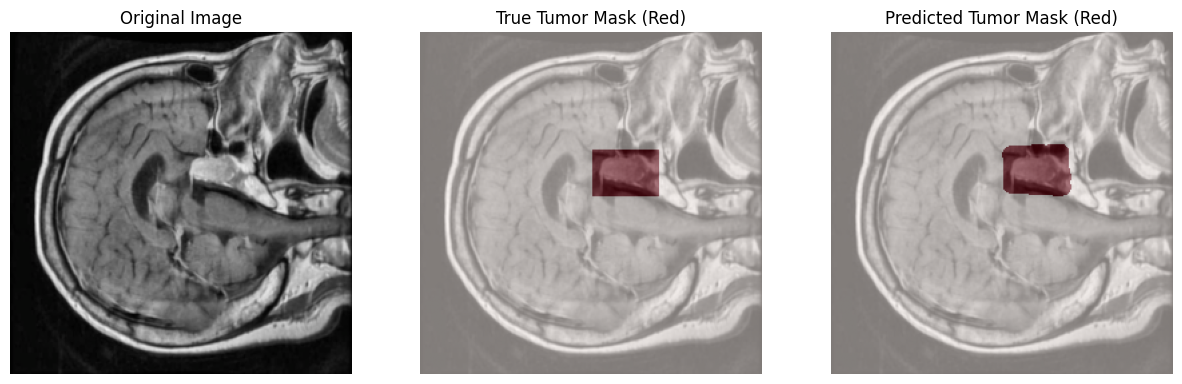

Sample 3:


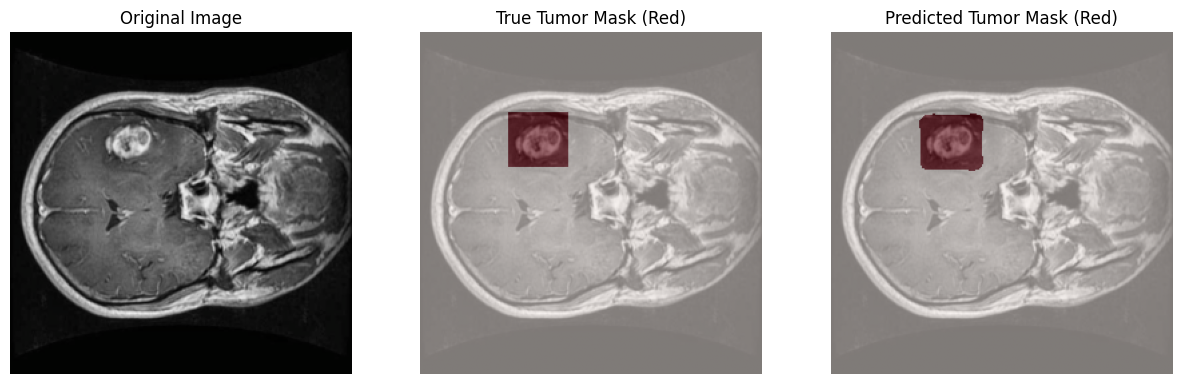

Sample 4:


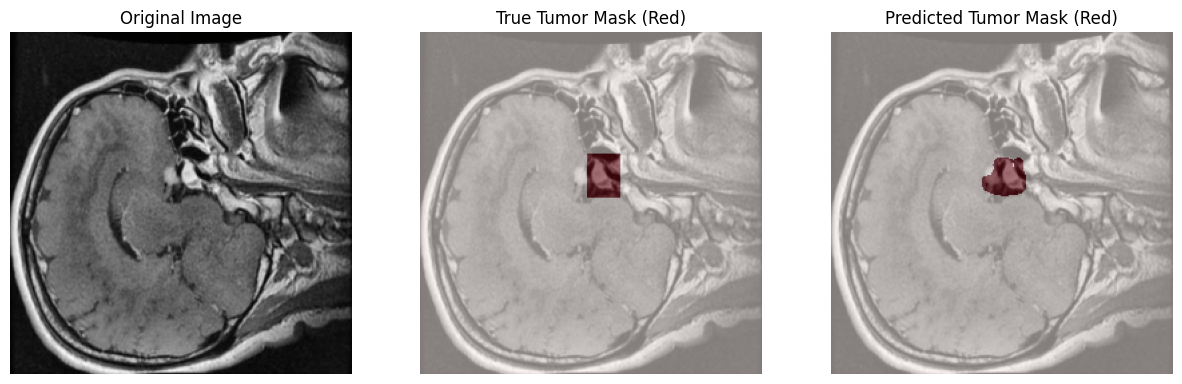

Sample 5:


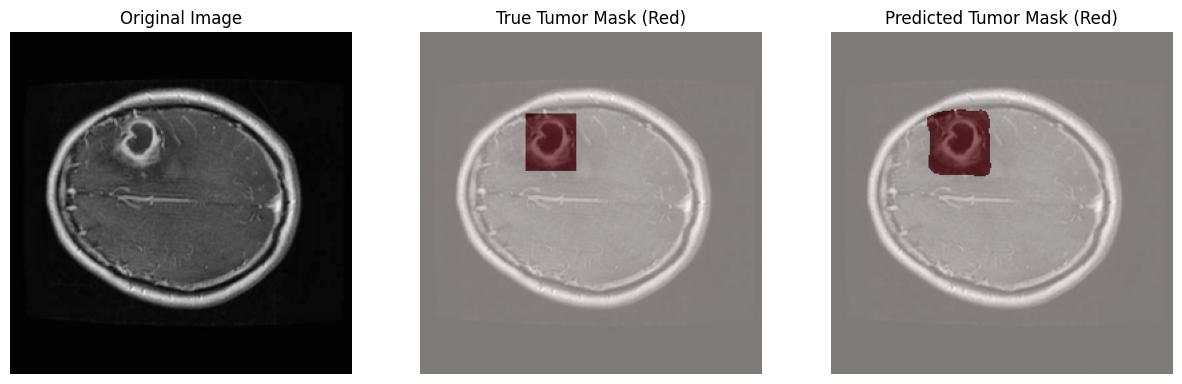

In [ ]:
try:
    model.load_state_dict(torch.load("best_model.pth"))
    model.to(device)
    model.eval()
    print("Best model loaded for inference.")
except FileNotFoundError:
    print("No 'best_model.pth' found. Make sure to train the model first.")

def visualize_prediction(model, image_tensor, true_mask_tensor, device):
    model.eval()
    with torch.no_grad():
        image_input = image_tensor.unsqueeze(0).to(device)
        output_mask = model(image_input)
        predicted_mask = (output_mask.squeeze().cpu().numpy() > 0.5).astype(np.float32)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image (unnormalize for display)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_display = inv_normalize(image_tensor).permute(1, 2, 0).cpu().numpy()
    true_mask_display = true_mask_tensor.squeeze().cpu().numpy()

    axes[0].imshow(image_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # True Mask
    axes[1].imshow(image_display, cmap='gray')
    axes[1].imshow(true_mask_display, cmap='Reds', alpha=0.5)
    axes[1].set_title("True Tumor Mask (Red)")
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(image_display, cmap='gray')
    axes[2].imshow(predicted_mask, cmap='Reds', alpha=0.5)
    axes[2].set_title("Predicted Tumor Mask (Red)")
    axes[2].axis('off')

    plt.show()

# Visualize a few samples from the validation set
print("\nVisualizing predictions on validation data:")
num_samples_to_visualize = 5
for i, (images, masks) in enumerate(val_loader):
    if i >= num_samples_to_visualize:
        break
    print(f"Sample {i+1}:")
    visualize_prediction(model, images[0], masks[0], device)

In [ ]:
##### For Grad-Cam #####
##### In Progress  #####

import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms

# Load trained model
model.eval()

# Hook for feature maps
feature_maps = None
gradients = None

def save_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output

def save_gradients(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0] # grad_output is a tuple

# Choose target convolutional layer.
# This should be a layer whose activations need analyze.
target_layer = model.dec1

# Register hooks
feature_handle = target_layer.register_forward_hook(save_feature_maps)
gradient_handle = target_layer.register_backward_hook(save_gradients)

def generate_grad_cam_heatmap(input_image_tensor, target_class_idx, target_pixel_coords=None):

    # Ensure input is on the same device as the model
    input_image_tensor = input_image_tensor.to(next(model.parameters()).device)

    # Clear previous gradients
    model.zero_grad()

    # Forward pass
    output = model(input_image_tensor) # (1, num_classes, H, W)

    if target_pixel_coords:
        target_output_value = output[0, target_class_idx, target_pixel_coords[1], target_pixel_coords[0]]
    else:
        target_output_value = output[0, target_class_idx, :, :].sum()

    # Backward pass
    target_output_value.backward(retain_graph=True)

    # Get feature maps and gradients
    activations = feature_maps.detach()
    grads = gradients.detach()

    weights = F.adaptive_avg_pool2d(grads, 1)

    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)

    # Upsample to original image size
    heatmap = F.interpolate(cam, size=(input_image_tensor.shape[2], input_image_tensor.shape[3]), mode='bilinear', align_corners=False)
    heatmap = heatmap.squeeze().cpu().numpy()

    # Normalize heatmap to 0-1
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8) # Add epsilon for stability

    return heatmap

def visualize_heatmap(original_image_path, heatmap_array, alpha=0.6):
    """
    Overlays a heatmap on the original image.

    Args:
        original_image_path (str): Path to the original image file.
        heatmap_array (np.ndarray): The heatmap array (0-1 normalized).
        alpha (float): Transparency factor for the heatmap.
    """
    original_img = cv2.imread(original_image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (heatmap_array.shape[1], heatmap_array.shape[0])) # Resize to match heatmap

    # Convert heatmap to BGR to apply colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_array), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) # Convert back to RGB for matplotlib/PIL

    # Overlay heatmap on original image
    overlaid_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)

    # Convert to PIL Image for display
    return Image.fromarray(overlaid_img)

image_path = "brain_mri.jpg"
Image.new('RGB', (256, 256), color = 'red').save(image_path)
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
draw.ellipse((80, 80, 180, 180), fill=(0, 0, 255)) # Blue ellipse as a tumor
img.save(image_path)

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
IMG_SIZE = 256

input_img = Image.open(image_path).convert("RGB")
input_tensor = preprocess(input_img).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_tensor = input_tensor.to(device)

heatmap = generate_grad_cam_heatmap(input_tensor, target_class_idx=1)

# Visualize the heatmap
overlaid_image = visualize_heatmap(image_path, heatmap)
print("Here's the Grad-CAM heatmap overlaid on your image, highlighting regions contributing to the tumor prediction:")
overlaid_image

feature_handle.remove()
gradient_handle.remove()